[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-summarization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239436-lesson-5-chatbot-w-summarizing-messages-and-memory)

# Political Discussion Chatbot

## Overview

This chatbot is designed to engage in political discussions while maintaining:
- Factual accuracy
- Balanced perspectives
- Historical context
- Civil discourse

## Goals

The chatbot will:
- Engage in political discussions across various topics
- Maintain context of the conversation
- Provide factual information with proper context
- Summarize complex political discussions
- Keep track of user's political interests and knowledge level

We'll use LangGraph to create a politically-focused chatbot that can maintain long-running conversations about political topics while efficiently managing memory through summarization.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [4]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o",temperature=0)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [5]:
from langgraph.graph import MessagesState
from typing import Optional, List

class State(MessagesState):
    summary: str
    topics_discussed: Optional[List[str]] = []  # Track political topics discussed
    stance: Optional[str] = None  # Track if any particular stance has been expressed
    knowledge_level: Optional[str] = None  # Track user's knowledge level on political topics

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get existing context
    summary = state.get("summary", "")
    topics = state.get("topics_discussed", [])
    stance = state.get("stance", "")
    knowledge_level = state.get("knowledge_level", "")
    
    # Build system message with political discussion guidelines
    system_message = """You are a politically informed chatbot that engages in balanced political discussions.
Key guidelines:
- Maintain factual accuracy and cite sources when possible
- Present balanced perspectives on political issues
- Avoid partisan bias while acknowledging different viewpoints
- Keep discussions civil and respectful
- Focus only on political topics and redirect non-political conversations back to politics
"""

    # Add context if it exists
    if summary:
        system_message += f"\nPrevious conversation summary: {summary}"
    if topics:
        system_message += f"\nTopics discussed: {', '.join(topics)}"
    if stance:
        system_message += f"\nUser's expressed stance: {stance}"
    if knowledge_level:
        system_message += f"\nUser's knowledge level: {knowledge_level}"

    # Create messages list with system message
    messages = [SystemMessage(content=system_message)] + state["messages"]
    
    # Get response
    response = model.invoke(messages)
    
    # Update state with any new political context
    new_state = {"messages": response}
    
    return new_state

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [7]:
def summarize_conversation(state: State):
    
    # Get existing context
    summary = state.get("summary", "")
    topics = state.get("topics_discussed", [])

    # Create our political summarization prompt 
    if summary:
        summary_message = (
            f"Previous political discussion summary: {summary}\n\n"
            "Please extend this summary focusing on:\n"
            "1. Key political topics and positions discussed\n"
            "2. Any factual claims or statistics mentioned\n"
            "3. The level of political knowledge demonstrated\n"
            "4. Areas where clarification or more context was needed\n\n"
            "Analyze the new messages above and update the summary:"
        )
    else:
        summary_message = (
            "Create a summary of this political discussion focusing on:\n"
            "1. Key political topics and positions discussed\n"
            "2. Any factual claims or statistics mentioned\n"
            "3. The level of political knowledge demonstrated\n"
            "4. Areas where clarification or more context was needed"
        )

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Extract topics from the conversation
    topic_message = (
        "Based on the conversation above, list the main political topics discussed "
        "as a comma-separated list (e.g., 'healthcare reform, foreign policy, tax policy'):"
    )
    topic_response = model.invoke(messages + [HumanMessage(content=topic_message)])
    new_topics = [t.strip() for t in topic_response.content.split(",")]
    
    # Combine with existing topics
    all_topics = list(set(topics + new_topics))
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    
    return {
        "summary": response.content,
        "messages": delete_messages,
        "topics_discussed": all_topics
    }

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [8]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

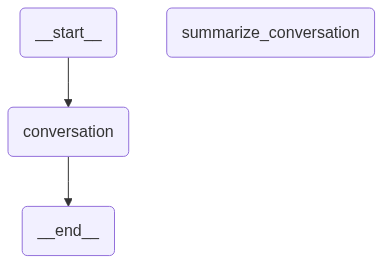

In [9]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start political conversation
input_message = HumanMessage(content="What do you think about the current state of democracy?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="How does the electoral college work?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="What are the main arguments for and against electoral college reform?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [ ]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [ ]:
input_message = HumanMessage(content="What role do swing states play in presidential elections?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes, Nick Bosa is indeed one of the highest-paid defensive players in the NFL. In September 2023, he signed a record-breaking contract extension with the San Francisco 49ers, making him the highest-paid defensive player at that time. His performance on the field has certainly earned him that recognition. It's great to hear you're a fan of such a talented player!


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_18661/23381741.py:23: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]


In [ ]:
graph.get_state(config).values.get("summary","")

"Lance introduced himself and mentioned that he is a fan of the San Francisco 49ers. He specifically likes Nick Bosa and inquired if Bosa is the highest-paid defensive player. I confirmed that Nick Bosa signed a record-breaking contract extension in September 2023, making him the highest-paid defensive player at that time, and acknowledged Bosa's talent and Lance's enthusiasm for the player."